# 時系列データの特徴量の算出

## データの読み込みと可視化

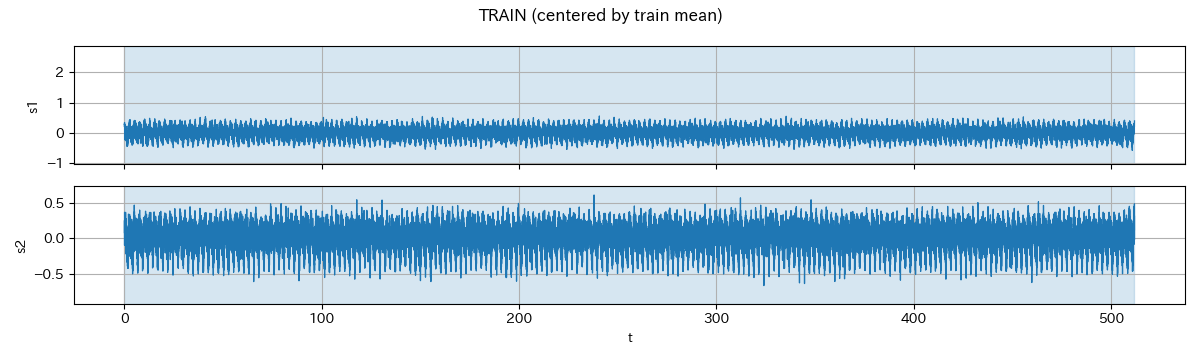

C:\Users\tsenz\AppData\Local\Temp\ipykernel_18312\1534846647.py:132: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(n, 1, sharex=True, figsize=(12, max(3.2, 1.8 * n)))


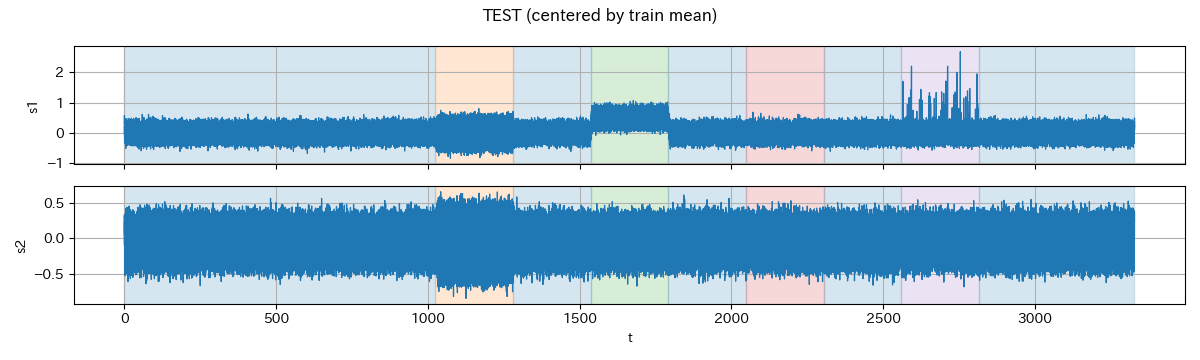

In [25]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ============================================================
# 設定（ここだけ）
# ============================================================
TRAIN_CSV = r"data_train_Smooth.csv"
TEST_CSV  = r"data_test_Smooth.csv"

# 指定しなければ（Noneなら）：
# TIME_COL  -> 行番号を時刻扱い
# LABEL_COL -> ラベル無し（背景塗り無し）
TIME_COL  = "t"      # 例: "t"
LABEL_COL = "label"  # 例: "label"

VALUE_COLS = ["s1","s2"]  # 必ず指定


# ============================================================
# CSV読み込み（落ちにくく）
# ============================================================
def read_csv_robust(path: str) -> pd.DataFrame:
    last_err = None
    for enc in ("utf-8-sig", "utf-8", "cp932", "shift_jis"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    try:
        return pd.read_csv(path, encoding_errors="replace")
    except Exception as e:
        raise RuntimeError(f"CSVが読み込めませんでした: {path}\n最後のエラー: {last_err}\n最終試行エラー: {e}")


# ============================================================
# センタ（学習平均との差し引きを学習・テストに適用）
# ============================================================
def center_by_train_mean(df_tr: pd.DataFrame, df_te: pd.DataFrame, cols: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    base = df_tr[cols].mean(axis=0, skipna=True)
    tr_c = df_tr.copy()
    te_c = df_te.copy()
    tr_c[cols] = tr_c[cols] - base
    te_c[cols] = te_c[cols] - base
    return tr_c, te_c


# ============================================================
# ラベル区間（ラベルが変わるたびに区間分割）
# ============================================================
def label_segments(x: np.ndarray, labels: np.ndarray):
    if labels.size == 0:
        return []

    lab = labels.astype(object)
    for i in range(lab.size):
        if pd.isna(lab[i]):
            lab[i] = "NaN"

    segs = []
    start_i = 0
    for i in range(1, lab.size):
        if lab[i] != lab[i - 1]:
            segs.append((x[start_i], x[i - 1], lab[i - 1]))
            start_i = i
    segs.append((x[start_i], x[-1], lab[-1]))
    return segs


# ============================================================
# 学習・テストで共通のylim（列ごと）
# ============================================================
def compute_ylims(df_a: pd.DataFrame, df_b: pd.DataFrame, cols: list[str]) -> dict[str, tuple[float, float]]:
    ylims = {}
    for c in cols:
        ya = pd.to_numeric(df_a[c], errors="coerce").to_numpy(dtype=float)
        yb = pd.to_numeric(df_b[c], errors="coerce").to_numpy(dtype=float)
        y = np.concatenate([ya, yb])
        y = y[np.isfinite(y)]
        if y.size == 0:
            ylims[c] = (-1.0, 1.0)
            continue
        lo, hi = float(np.min(y)), float(np.max(y))
        if lo == hi:
            lo -= 1.0
            hi += 1.0
        pad = 0.05 * (hi - lo)
        ylims[c] = (lo - pad, hi + pad)
    return ylims


# ============================================================
# タイル（縦並び）プロット：背景ラベル塗り
# ============================================================
def plot_tiled_timeseries(
    df: pd.DataFrame,
    time_col: str | None,
    value_cols: list[str],
    label_col: str | None,
    title: str,
    ylims_by_col: dict[str, tuple[float, float]],
):
    if time_col is None:
        x = np.arange(len(df), dtype=float)
        x_label = "index"
    else:
        x = pd.to_numeric(df[time_col], errors="coerce").to_numpy(dtype=float)
        if np.isnan(x).all():
            x = np.arange(len(df), dtype=float)
            x_label = "index"
        else:
            x_label = time_col

    segs = []
    label_to_color = {}
    if label_col is not None and label_col in df.columns:
        labs = df[label_col].to_numpy()
        segs = label_segments(x, labs)

        uniq = []
        for _, _, lb in segs:
            if lb not in uniq:
                uniq.append(lb)

        cmap = plt.get_cmap("tab10")
        for i, lb in enumerate(uniq):
            label_to_color[lb] = cmap(i % 10)

    n = len(value_cols)
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(12, max(3.2, 1.8 * n)))
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, value_cols):
        y = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)

        if segs:
            for xs, xe, lb in segs:
                ax.axvspan(xs, xe, alpha=0.18, color=label_to_color.get(lb, None))

        ax.plot(x, y, linewidth=0.9)
        ax.set_ylabel(col)
        ax.set_ylim(*ylims_by_col[col])
        ax.grid(True)

    axes[-1].set_xlabel(x_label)
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


# ============================================================
# 実行部（上から順に流す）
# ============================================================
# 前提：
# - LABEL_COL は必ず存在する（Noneではない、列もある）
# - TIME_COL は None なら行番号、指定するなら列がある
# - VALUE_COLS は必ず列として存在する

df_tr = read_csv_robust(TRAIN_CSV)
df_te = read_csv_robust(TEST_CSV)

df_tr_c, df_te_c = center_by_train_mean(df_tr, df_te, VALUE_COLS)
ylims = compute_ylims(df_tr_c, df_te_c, VALUE_COLS)

plot_tiled_timeseries(
    df_tr_c,
    time_col=TIME_COL,
    value_cols=VALUE_COLS,
    label_col=LABEL_COL,
    title="TRAIN (centered by train mean)",
    ylims_by_col=ylims,
)

plot_tiled_timeseries(
    df_te_c,
    time_col=TIME_COL,
    value_cols=VALUE_COLS,
    label_col=LABEL_COL,
    title="TEST (centered by train mean)",
    ylims_by_col=ylims,
)


## 周期性の確認

In [26]:
import numpy as np
import pandas as pd
from scipy import signal
from statsmodels.tsa.stattools import acf as sm_acf


def periodicity_scores_with_curves(x, lag_min=20, lag_max=2000, top_k=5, psd_nperseg=2048):
    """
    time_col無し前提で統一（fs=1.0）
    - ACF/PSDの曲線を1回だけ計算
    - その曲線からピーク候補dfを作成
    戻り: (df_scores, ac, lags, f, Pxx, mask)
    """
    fs = 1.0

    x = np.asarray(x, dtype=float).ravel()
    if np.any(~np.isfinite(x)):
        med = np.nanmedian(x)
        x = np.where(np.isfinite(x), x, med)

    # 平均引きはここで1回だけ
    x = signal.detrend(x, type="constant")

    n = x.size
    lag_max = int(min(lag_max, n - 2))
    lag_min = int(max(1, lag_min))
    if lag_max <= lag_min:
        raise ValueError("lag範囲が不正です（データ長 or lag_min/lag_max を見直し）")

    # --- 曲線（1回だけ計算） ---
    ac = sm_acf(x, nlags=lag_max, fft=True, missing="drop")
    lags = np.arange(ac.size, dtype=float)

    # welchは detrend=False にして二重平均引きを避ける（上で引いたため）
    f, Pxx = signal.welch(
        x, fs=fs, window="hann", nperseg=psd_nperseg, detrend=False, scaling="density"
    )

    fmin = max(1e-12, fs / lag_max)         # = 1/lag_max
    fmax = min(0.5 * fs, fs / lag_min)      # = min(0.5, 1/lag_min)
    m = (f >= fmin) & (f <= fmax) & np.isfinite(Pxx)

    # --- 曲線からピーク候補を抽出 ---
    def _top_peaks(y, axis, method, axis_kind):
        y = np.asarray(y, dtype=float)
        axis = np.asarray(axis, dtype=float)
        if y.size == 0:
            return pd.DataFrame()

        peaks, _ = signal.find_peaks(y)  # しきい値なし
        if peaks.size == 0:
            return pd.DataFrame()

        prom = signal.peak_prominences(y, peaks)[0].astype(float)
        wid = signal.peak_widths(y, peaks, rel_height=0.5)[0].astype(float)

        order = np.argsort(prom)[::-1][:top_k]
        rows = []

        if axis_kind == "freq":
            d_axis = float(np.median(np.diff(axis))) if axis.size >= 2 else np.nan

        for rk, i in enumerate(order, start=1):
            p = int(peaks[i])
            ax = float(axis[p])

            if axis_kind == "lag":
                T = int(round(ax))
                rows.append({
                    "method": method,
                    "rank": rk,
                    "period_samples": T,
                    "freq_hz": float(1.0 / T) if T > 0 else np.nan,  # cycles/sample
                    "peak": float(y[p]),
                    "prominence": float(prom[i]),
                    "width": float(wid[i]),
                    "width_unit": "samples",
                })
            else:
                f0 = ax  # cycles/sample
                rows.append({
                    "method": method,
                    "rank": rk,
                    "period_samples": float(1.0 / (f0 + 1e-12)),
                    "freq_hz": float(f0),
                    "peak": float(y[p]),
                    "prominence": float(prom[i]),
                    "width": float(wid[i] * d_axis) if np.isfinite(d_axis) else np.nan,
                    "width_unit": "cycles/sample",
                })
        return pd.DataFrame(rows)

    df_acf = _top_peaks(
        y=ac[lag_min:lag_max + 1],
        axis=lags[lag_min:lag_max + 1],
        method="acf",
        axis_kind="lag",
    )
    df_psd = _top_peaks(
        y=Pxx[m],
        axis=f[m],
        method="psd_welch",
        axis_kind="freq",
    )

    df_scores = pd.concat([df_acf, df_psd], ignore_index=True).sort_values(["method", "rank"]).reset_index(drop=True)
    return df_scores, ac, lags, f, Pxx, m, lag_min, lag_max




,method,rank,period_samples,freq_hz,peak,prominence,width,width_unit
0,acf,1,255.000000,0.003922,0.640253,1.004710,78.713746,samples
1,acf,2,514.000000,0.001946,0.637305,1.001113,78.744013,samples
2,acf,3,768.000000,0.001302,0.637530,0.999183,78.342056,samples
3,acf,4,1025.000000,0.000976,0.630848,0.989927,78.573367,samples
4,acf,5,1280.000000,0.000781,0.627929,0.985312,78.744104,samples
5,psd_welch,1,256.000000,0.003906,16.385931,16.368220,0.000652,cycles/sample
6,psd_welch,2,128.000000,0.007812,5.362226,5.344096,0.000654,cycles/sample
7,psd_welch,3,85.333333,0.011719,2.255358,2.240141,0.000656,cycles/sample
8,psd_welch,4,51.200000,0.019531,0.808638,0.792369,0.000665,cycles/sample
9,psd_welch,5,30.567164,0.032715,0.029396,0.015160,0.001443,cycles/sample


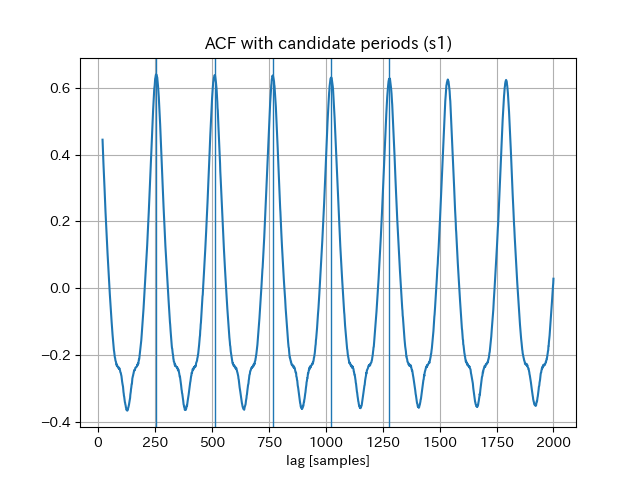

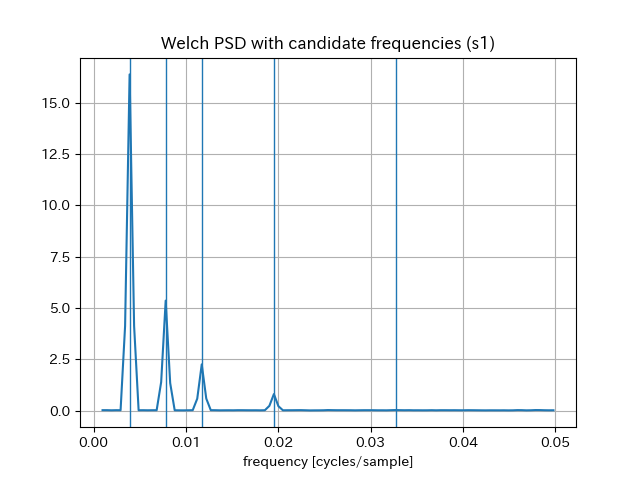

In [27]:
# ------------------------------------------------------------
# 実行（代表センサを選んで周期候補を出す）
# ------------------------------------------------------------
SENSOR_FOR_PERIOD = VALUE_COLS[0]
x = pd.to_numeric(df_tr_c[SENSOR_FOR_PERIOD], errors="coerce").to_numpy(dtype=float)

df_scores, ac, lags, f, Pxx, m, lag_min, lag_max = periodicity_scores_with_curves(
    x,
    lag_min=20,        # 探索する「最小周期」[samples]
                      # - time_col無し前提なので 1サンプル=1単位
                      # - これより短い周期（高周波）は候補から除外
                      # - 例：最短で20サンプル周期以上を見たい → lag_min=20

    lag_max=2000,      # 探索する「最大周期」[samples]
                      # - これより長い周期（低周波）は候補から除外
                      # - 例：最大で2000サンプル周期まで探す → lag_max=2000
                      # - 注意：データ長が短いと自動で n-2 に丸められる

    top_k=5,           # 各手法（ACF / PSD）で上位いくつの候補を返すか
                      # - prominence（目立ち度）が大きい順に top_k 個
                      # - 例：上位5候補だけ見たい → top_k=5

    psd_nperseg=2048,  # Welch PSD の 1区間の長さ（FFTをかける窓長）[samples]
                      # - 大きいほど周波数分解能が上がり、ピーク周波数が細かく分かる
                      # - ただし平均に使う区間数が減り、ノイズでPSDが揺れやすくなる
                      # - 小さいほど分解能は落ちるが、平均回数が増えて滑らかになりやすい
                      # - 一般に「lag_max と同程度〜数倍」か「データ長の1/4程度」から試す
                      # - SciPy welch は nperseg > len(x) のとき自動で len(x) に丸める
)

display(df_scores)

# ------------------------------------------------------------
# 可視化：ACF（候補周期に縦線）
# ------------------------------------------------------------
T_list = df_scores.loc[df_scores["method"] == "acf", "period_samples"].dropna().tolist()

plt.figure()
plt.plot(lags[lag_min:lag_max + 1], ac[lag_min:lag_max + 1])
for T in T_list:
    plt.axvline(float(T), linewidth=1)
plt.xlabel("lag [samples]")
plt.title(f"ACF with candidate periods ({SENSOR_FOR_PERIOD})")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 可視化：Welch PSD（候補周波数に縦線）
# ------------------------------------------------------------
f_list = df_scores.loc[df_scores["method"] == "psd_welch", "freq_hz"].dropna().tolist()

plt.figure()
plt.plot(f[m], Pxx[m])
for f0 in f_list:
    plt.axvline(float(f0), linewidth=1)
plt.xlabel("frequency [cycles/sample]")
plt.title(f"Welch PSD with candidate frequencies ({SENSOR_FOR_PERIOD})")
plt.grid(True)


## この図は何か（Welch PSD）

この図は「周波数ごとの強さ（エネルギー）」を並べたものです。

- 横軸：frequency [cycles/sample]
  - time_col を使わない前提なので **cycles/sample（1サンプルあたり何回繰り返すか）**
- 縦軸：PSD（その周波数成分の強さ）
  - 値が大きいほど、その周波数の繰り返し成分が強い

曲線の**山（ピーク）**が「周期性が強い周波数」です。

---

## 「周波数」から「周期（サンプル数）」への変換

横軸が cycles/sample のとき、周期（何サンプルで1回繰り返すか）は

$$
\text{period\_samples} \approx \frac{1}{f}
$$

例：
- f = 0.01 cycles/sample → period ≈ 1/0.01 = 100 samples
- f = 0.003 cycles/sample → period ≈ 333 samples

---

## 青い縦線は何か

青い縦線は、`df_scores` の `method == "psd_welch"` が選んだ
「候補周波数（上位 top_k）」の位置です。

- 曲線（PSD）：周波数ごとの強さ
- 縦線：候補（この周波数が周期っぽい）

**縦線がPSDのピーク頂上付近に刺さっていれば、その候補は妥当**です。

---

## なぜピークが複数あるのか（基本周波数と高調波）

ピークが複数出るのは普通です。

波形が「きれいな正弦波」ではなく、
尖り・段差・歪みがあると、次が同時に出ます。

- 基本周波数：いちばんゆっくりした“本体の繰り返し”
- 高調波：基本周波数の 2倍、3倍… の成分

そのため
「一番高いピーク = 本当の周期」とは限りません。

例：
- 本当の基本周波数が f0 = 0.005（周期200）
- 2倍の 0.01（周期100）が強く見えることもある

---


## データを窓ごとに整理

In [28]:
import numpy as np
import pandas as pd


# ============================================================
# 1) 連続データ(df)を「1行=1窓」に変換（窓は全センサで同じ切り方）
# ============================================================
def make_window_starts(n, win, step):
    """
    n: 全長（サンプル数）
    win: 窓長（サンプル数）
    step: ステップ（サンプル数）
    戻り: starts（各窓の開始インデックス配列）
    """
    if win <= 0 or step <= 0:
        raise ValueError("win, step は正の整数にしてください")
    if n < win:
        return np.array([], dtype=int)
    return np.arange(0, n - win + 1, step, dtype=int)


def windowize_df(
    df: pd.DataFrame,
    sensor_cols: list[str],
    win: int,
    step: int,
    time_col: str | None = None,
    label_col: str | None = None,
    label_rule: str = "center",   # "center" / "majority"
):
    """
    目的：
      - df（時刻, センサ列..., ラベル列...）から、センサごとに
        X[sensor] = shape(n_win, win) の「1行=1窓」行列を作る
      - 併せて、各窓の開始/終了/中心インデックス、(あれば)中心時刻、(あれば)窓ラベル を meta にまとめる

    戻り：
      X_dict: {sensor_name: np.ndarray(n_win, win)}
      meta  : pd.DataFrame（各窓の情報）
    """
    # --- 列チェック（必要なら外してOK）
    for c in sensor_cols:
        if c not in df.columns:
            raise ValueError(f"sensor_cols に指定した列がありません: {c}")
    if time_col is not None and time_col not in df.columns:
        raise ValueError(f"time_col が df にありません: {time_col}")
    if label_col is not None and label_col not in df.columns:
        raise ValueError(f"label_col が df にありません: {label_col}")

    n = len(df)
    starts = make_window_starts(n, win, step)
    n_win = starts.size

    # --- meta（窓の位置情報）
    meta = pd.DataFrame({
        "win_i": np.arange(n_win, dtype=int),
        "start_idx": starts,
        "end_idx": starts + win - 1,
        "center_idx": starts + (win // 2),
    })

    # --- 時刻（あれば）
    if time_col is not None:
        t = pd.to_numeric(df[time_col], errors="coerce").to_numpy(dtype=float)
        meta["center_time"] = t[meta["center_idx"].to_numpy(dtype=int)]

    # --- ラベル（あれば）
    if label_col is not None:
        lab = df[label_col].to_numpy()
        if label_rule == "center":
            meta["win_label"] = lab[meta["center_idx"].to_numpy(dtype=int)]
        elif label_rule == "majority":
            # 多数決（カテゴリでもOK）
            wl = []
            for s in starts:
                seg = lab[s:s + win]
                # NaN除外
                seg = seg[~pd.isna(seg)]
                if seg.size == 0:
                    wl.append(np.nan)
                else:
                    v, cnt = np.unique(seg, return_counts=True)
                    wl.append(v[int(np.argmax(cnt))])
            meta["win_label"] = wl
        else:
            raise ValueError("label_rule は 'center' か 'majority' を指定してください")

    # --- センサごとの X を作る（全センサ同じ starts を使う）
    X_dict = {}
    for c in sensor_cols:
        x = pd.to_numeric(df[c], errors="coerce").to_numpy(dtype=float)
        # 1行=1窓（n_win, win）
        X = np.stack([x[s:s + win] for s in starts], axis=0) if n_win else np.empty((0, win), dtype=float)
        X_dict[c] = X

    return X_dict, meta



In [29]:

# ============================================================
# 2) 使い方（train/test どちらにも同じ関数を使う）
# ============================================================
df_tr = read_csv_robust(TRAIN_CSV)
df_te = read_csv_robust(TEST_CSV)

# センサ列
SENSOR_COLS = VALUE_COLS

# 窓設定（任意）
WIN  = 256
STEP = 256  # 256なら非重複、128なら50%重複
X_tr_dict, meta_tr = windowize_df(df_tr, SENSOR_COLS, WIN, STEP, time_col=TIME_COL, label_col=LABEL_COL, label_rule="center")
X_te_dict, meta_te = windowize_df(df_te, SENSOR_COLS, WIN, STEP, time_col=TIME_COL, label_col=LABEL_COL, label_rule="center")

# 例：s1 の「1行=1窓」行列
X_tr_s1 = X_tr_dict["s1"]   # shape (n_win, WIN)
X_te_s1 = X_te_dict["s1"]

X_te_s1
meta_te

,win_i,start_idx,end_idx,center_idx,center_time,win_label
0,0,0,255,128,1.28,0
1,1,256,511,384,3.84,0
2,2,512,767,640,6.40,0
3,3,768,1023,896,8.96,0
4,4,1024,1279,1152,11.52,0
...,...,...,...,...,...,...
1295,1295,331520,331775,331648,3316.48,0
1296,1296,331776,332031,331904,3319.04,0
1297,1297,332032,332287,332160,3321.60,0
1298,1298,332288,332543,332416,3324.16,0


## 特徴量の算出（wavelet変換、CWTで出力）

In [30]:
import numpy as np
import pandas as pd
import pywt


# ============================================================
# CWT用 scale（スケール）設計
# ============================================================
def make_scales_simple(n_scales: int = 64, start: float = 1.0, step: float = 1.0) -> np.ndarray:
    """
    いちばん単純な scale の作り方。

    scale は「ウェーブレット（短い波形）を横に伸ばす倍率」です。
      - scale が小さい  -> 短い波で照合 -> 速い変化（高周波）に敏感
      - scale が大きい  -> 長い波で照合 -> 遅い変化（低周波）に敏感

    この関数は「とりあえず S 本のスケールでCWTを作ってAEに入れる」用途向けで、
    周波数帯域を厳密に指定しない（まず動かす）ときに使います。

    返り値:
      scales: shape (S,)
        例: make_scales_simple(64) -> [1,2,3,...,64]
    """
    if n_scales <= 0:
        raise ValueError("n_scales は正の整数にしてください")
    if step <= 0:
        raise ValueError("step は正の値にしてください")
    # start から step ずつ増やして n_scales 本
    scales = start + step * np.arange(n_scales, dtype=float)
    return scales.astype(float)


def make_scales_from_freq_range(
    wavelet: str,
    fs: float,
    win: int,
    n_scales: int = 64,
    fmax_ratio: float = 0.4,
    fmin_cycles_per_win: float = 2.0,
    spacing: str = "log",
) -> np.ndarray:
    """
    「見たい周波数帯」を先に決めて、そこをカバーする scales を作る推奨法。

    なぜ推奨か:
      - scale は wavelet の種類に依存するため「scale=64が何Hzか」は固定ではない
      - 先に周波数帯（低～高）を決め、そこを均等に（例：対数間隔で）見る方が説明可能

    入力の意味:
      wavelet:
        例 "cmor1.5-1.0"（複素モルレー）
      fs:
        サンプリング周波数 [Hz]
        注意: 横軸が「秒」ではなく「角度0-360」などの場合、fs=1.0にして
              freqs は「cycles / sample（1サンプルあたりの回数）」として扱うのが安全です。
      win:
        窓長（サンプル数）。低周波側の下限決めに使います。
      n_scales:
        出力スケール本数（=CWT画像の縦サイズS）
      fmax_ratio:
        高周波側の上限 f_max を fs に対する比で決める目安
        例: 0.4 -> f_max ≈ 0.4*fs（0.5*fs が理論上限ナイキストなので少し余裕）
      fmin_cycles_per_win:
        低周波側の下限 f_min の目安（「窓内で何周期ぶん見たいか」）
        例: 2.0 -> 窓の中で2周期分は回るくらいの周波数まで見る
            f_min ≈ 2 / (win/fs)
      spacing:
        "log"  -> 周波数を対数間隔（低周波まで幅広く扱いやすい）
        "linear"-> 周波数を線形間隔

    返り値:
      scales: shape (n_scales,)
        この scales を pywt.cwt に渡すと、概ね [f_min, f_max] をカバーするCWTになります。
    """
    if fs <= 0:
        raise ValueError("fs は正の値にしてください")
    if win <= 1:
        raise ValueError("win は2以上にしてください")
    if n_scales <= 0:
        raise ValueError("n_scales は正の整数にしてください")
    if not (0 < fmax_ratio <= 0.5):
        raise ValueError("fmax_ratio は (0, 0.5] の範囲で指定してください（0.5がナイキスト上限）")
    if fmin_cycles_per_win <= 0:
        raise ValueError("fmin_cycles_per_win は正の値にしてください")
    if spacing not in ("log", "linear"):
        raise ValueError("spacing は 'log' か 'linear' を指定してください")

    dt = 1.0 / float(fs)        # 1サンプルの時間[sec]
    T_win = win * dt            # 窓の長さ[sec]

    f_max = float(fmax_ratio * fs)
    f_min = float(fmin_cycles_per_win / T_win)

    # f_min < f_max にならない設定はエラー
    if not (0 < f_min < f_max):
        raise ValueError(f"周波数範囲が不正です: f_min={f_min}, f_max={f_max}")

    # 見たい周波数点を作る（高→低の順）
    if spacing == "log":
        freqs_des = np.geomspace(f_max, f_min, int(n_scales))
    else:
        freqs_des = np.linspace(f_max, f_min, int(n_scales))

    # wavelet固有の中心周波数（尺度→周波数の変換の基準）
    # ここが「scaleはwaveletに依存する」の本体
    cf = pywt.central_frequency(wavelet)

    # 周波数 f に対応する scale の目安:
    #   f ≈ (cf / scale) / dt  →  scale ≈ cf / (f*dt)
    scales = cf / (freqs_des * dt)
    return scales.astype(float)


def scales_to_freqs(wavelet: str, scales: np.ndarray, fs: float) -> np.ndarray:
    """
    scales がだいたいどの周波数[Hz]に相当するかを確認するための関数。
    PyWaveletsの定義に従って scale->freq を変換します。

    注意:
      fs が「秒ベースのサンプリング周波数」でない場合は、Hzとして解釈しないでください。
      その場合は「cycles/sample」として相対比較用に使います。
    """
    scales = np.asarray(scales, dtype=float)
    sampling_period = 1.0 / float(fs)
    freqs = pywt.scale2frequency(wavelet, scales) / sampling_period
    return freqs.astype(float)


# ============================================================
# CWT特徴量（2次元: scale×time）をそのままテンソル化（NHWC）
# ============================================================
def cwt_tensor_nhwc_pywt(
    X_dict: dict[str, np.ndarray],   # {sensor: (N, T)}  例: {"s1": (n_win, WIN), "s2": ...}
    scales: np.ndarray,              # CWTのスケール配列（shape(S,)）
    fs: float = 1.0,                 # サンプリング周波数[Hz]（不明なら1.0でも計算可）
    wavelet: str = "cmor1.5-1.0",    # 複素モルレー（CWTでよく使う。係数は複素数になりやすい）
    use_log_power: bool = True,      # True: log10(|coeff|^2)（桁圧縮で学習が安定しやすい）
    eps: float = 1e-12,              # log(0)回避
    detrend_mean: bool = False,      # True: 窓平均を引く（上下シフトを消す）/ False: 残す
    out_dtype = np.float32,          # 出力dtype（TFへ渡すのでfloat32推奨）
):
    """
    目的:
      windowize_df等で作った「1行=1窓」のデータから、
      CWTの2次元(スケール×時間)を各サンプルごとに保持したテンソルを作る。
      TensorFlow(Keras)でそのまま使えるように NHWC 形式にする。

    ここで "特徴量" と言っているもの:
      - 1窓（1サンプル）に対して、CWTのパワー（|係数|^2）を計算し、
        shape(S, T) の 2次元配列として保持する
      - 位相（複素数の角度）は捨て、強さ（パワー）だけを使う
        （理由：AEへの入力を実数にし、安定に学習しやすくするため）

    入力:
      X_dict:
        センサごとの窓行列。各センサは shape (N, T)
        N: 窓数（サンプル数）
        T: 窓長（WIN）
      scales:
        shape (S,) のスケール配列（Sが縦サイズ）
      fs:
        1秒あたりのサンプル数（Hz）
      wavelet:
        例 "cmor1.5-1.0"
        cmor は複素モルレー系で、時間-周波数の見え方が安定しやすいことが多い
      detrend_mean:
        True にすると「窓全体の平均（直流成分）」を消す
        上下シフトも異常として検知したいなら False のまま

    出力:
      X_cwt: shape (N, S, T, C)  ※NHWC
        C: センサ数（チャネル数）
      freqs: shape (S,)
        scales に対応する周波数の目安
        ※fsが正しいときのみ Hz として意味がある
    """
    # ----------------------------
    # 0) 入力チェックと基本サイズ
    # ----------------------------
    sensors = list(X_dict.keys())
    if len(sensors) == 0:
        raise ValueError("X_dict が空です（センサがありません）")

    X0 = np.asarray(X_dict[sensors[0]], dtype=float)
    if X0.ndim != 2:
        raise ValueError("X_dict[sensor] は 2次元 (N,T) の配列にしてください")
    N, T = X0.shape

    scales = np.asarray(scales, dtype=float)
    if scales.ndim != 1 or scales.size == 0:
        raise ValueError("scales は 1次元の非空配列にしてください")
    S = int(scales.size)

    if fs <= 0:
        raise ValueError("fs は正の値にしてください")

    C = len(sensors)
    X_cwt = np.empty((N, S, T, C), dtype=out_dtype)

    # 1サンプルの時間間隔[sec]（Hzを意味づけるために必要）
    sampling_period = 1.0 / float(fs)

    # scales→freqs は「データ内容に依存しない」のでここで一回だけ計算
    freqs = pywt.scale2frequency(wavelet, scales) / sampling_period  # shape (S,)

    # ----------------------------
    # 1) CWTをセンサ×窓で回してテンソルに格納
    # ----------------------------
    for ci, sensor in enumerate(sensors):
        Xw = np.asarray(X_dict[sensor], dtype=float)
        if Xw.shape != (N, T):
            raise ValueError(f"shape不一致: {sensor} {Xw.shape} expected {(N, T)}")

        for i in range(N):
            x = Xw[i]  # shape (T,)

            # (a) 欠損を埋める（NaN/infがあるとpywt.cwtや学習が壊れる）
            if np.any(~np.isfinite(x)):
                m = np.nanmean(x)
                if not np.isfinite(m):
                    m = 0.0
                x = np.where(np.isfinite(x), x, m)

            # (b) 窓平均を引く（上下シフトを消したい場合だけ）
            if detrend_mean:
                x = x - float(np.mean(x))

            # (c) CWT係数を計算
            # coeffs: shape (S, T)
            #  - 行: scale（縦方向）
            #  - 列: 窓内の時刻（横方向）
            #  - 複素ウェーブレットの場合、coeffs は複素数になる
            coeffs, _ = pywt.cwt(
                x,
                scales,
                wavelet,
                sampling_period=sampling_period
            )

            # (d) 実数の2次元へ変換（位相を捨て、強さだけにする）
            #     パワー: |coeff|^2
            P = (np.abs(coeffs) ** 2).astype(np.float64)  # shape (S, T)

            # (e) 値の桁を圧縮（スケールによって値の大きさが変わりやすい）
            if use_log_power:
                P = np.log10(P + eps)

            # (f) テンソルへ格納
            X_cwt[i, :, :, ci] = P.astype(out_dtype, copy=False)

    return X_cwt, freqs.astype(np.float64)


# ============================================================
# （任意）学習用の正規化：trainで平均・標準偏差を推定してz化
# ============================================================
def fit_norm_global(X_train: np.ndarray, eps: float = 1e-12) -> tuple[float, float]:
    """
    CWTテンソル全体の平均・標準偏差（1値ずつ平坦化して計算）を返す。
    AE学習を安定させたいときの最小の正規化です。
    """
    v = np.asarray(X_train, dtype=np.float64).reshape(-1)
    m = float(np.mean(v))
    s = float(np.std(v, ddof=0))
    if not np.isfinite(s) or s < eps:
        s = eps
    return m, s

def apply_norm_global(X: np.ndarray, mean: float, std: float, eps: float = 1e-12) -> np.ndarray:
    """
    trainで得た mean/std を使って z化する（train/testで同じ変換にするのが重要）
    """
    std = max(float(std), eps)
    return ((X - float(mean)) / std).astype(np.float32, copy=False)

In [31]:
import numpy as np
import pandas as pd


# ---- サンプリング周波数 fs[Hz] ----
# TIME_COL を使わない（サンプル番号だけ）運用なら、まずは FS=1.0 でOKです。
# 「秒」ベースで周波数[Hz]として解釈したい場合は、正しい FS を入れてください。
FS = 1.0

# ============================================================
# 実行例：窓化済み X_tr_dict / X_te_dict から CWTテンソルを作る
#   出力: Xcwt_tr, Xcwt_te は (N, S, T, C) で TensorFlow のAEにそのまま入る
# ============================================================

# ---- 1) CWTの縦サイズ（=scale本数） ----
# まずは 64 本などが扱いやすい（AEのConv2Dでダウンサンプルしても形が崩れにくい）
N_SCALES = 64

# ---- 2) scale を作る（2通り） ----
# (A) まず動かすだけ：1..64
SCALES_SIMPLE = make_scales_simple(n_scales=N_SCALES, start=1.0, step=1.0)

# (B) 推奨：見たい周波数帯を決めてから scale を作る
#     fs と WIN が「秒ベース」で意味を持つ場合にのみ推奨
SCALES_RANGE= make_scales_from_freq_range(
    wavelet="cmor1.5-1.0",
    fs=FS,                 # 正しいfsを入れる（不明なら1.0だがHz解釈はしない）
    win=WIN,
    n_scales=N_SCALES,
    fmax_ratio=0.4,
    fmin_cycles_per_win=2.0,
    spacing="log",
)

# ここでは(A)を採用
SCALES = SCALES_SIMPLE
SCALES = SCALES_RANGE


# ---- 3) scale→周波数の対応を確認（freqsは「目安」） ----
freqs = scales_to_freqs(wavelet="cmor1.5-1.0", scales=SCALES, fs=FS)
df_map = pd.DataFrame({"scale": SCALES, "freq_hz_or_cycles_per_sample": freqs})
print(df_map.head(8))
print(df_map.tail(8))

# ---- 4) CWTテンソル化（2次元のまま） ----
Xcwt_tr, freqs_tr = cwt_tensor_nhwc_pywt(
    X_tr_dict,
    scales=SCALES,
    fs=FS,
    wavelet="cmor1.5-1.0",
    use_log_power=True,
    detrend_mean=False,  # 上下シフトも異常に含めたいなら False
)

Xcwt_te, freqs_te = cwt_tensor_nhwc_pywt(
    X_te_dict,
    scales=SCALES,
    fs=FS,
    wavelet="cmor1.5-1.0",
    use_log_power=True,
    detrend_mean=False,
)

print("Xcwt_tr:", Xcwt_tr.shape)  # (N, S, T, C)
print("Xcwt_te:", Xcwt_te.shape)

# ---- 5) （任意）学習前の正規化（推奨） ----
# AEは再構成誤差を使うので、train/testで同じ正規化を必ず使う
m, s = fit_norm_global(Xcwt_tr)
Xcwt_tr_n = apply_norm_global(Xcwt_tr, m, s)
Xcwt_te_n = apply_norm_global(Xcwt_te, m, s)

print("norm mean/std:", m, s)
print("Xcwt_tr_n:", Xcwt_tr_n.shape)

      scale  freq_hz_or_cycles_per_sample
0  2.500000                      0.400000
1  2.661162                      0.375776
2  2.832713                      0.353018
3  3.015323                      0.331639
4  3.209705                      0.311555
5  3.416617                      0.292687
6  3.636869                      0.274962
7  3.871318                      0.258310
         scale  freq_hz_or_cycles_per_sample
56   82.659179                      0.012098
57   87.987779                      0.011365
58   93.659886                      0.010677
59   99.697643                      0.010030
60  106.124623                      0.009423
61  112.965917                      0.008852
62  120.248232                      0.008316
63  128.000000                      0.007812
Xcwt_tr: (200, 64, 256, 2)
Xcwt_te: (1300, 64, 256, 2)
norm mean/std: -2.3394416375478704 0.8272747061034263
Xcwt_tr_n: (200, 64, 256, 2)


## 可視化（代表波形

labels: [0 1 2 3 4]
counts: {0: 900, 1: 100, 2: 100, 3: 100, 4: 100}


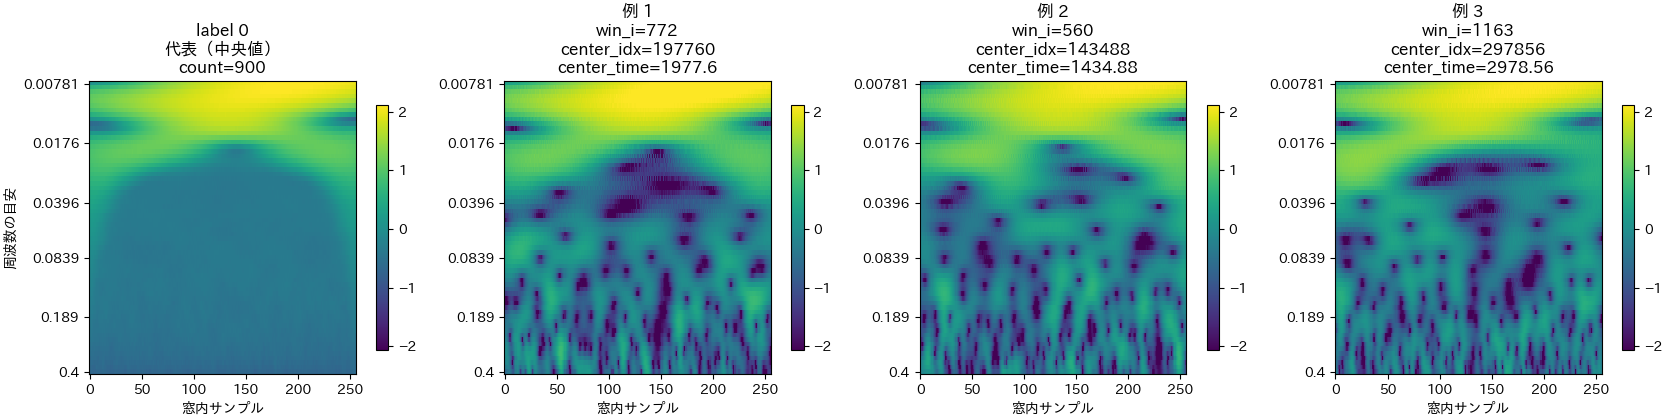

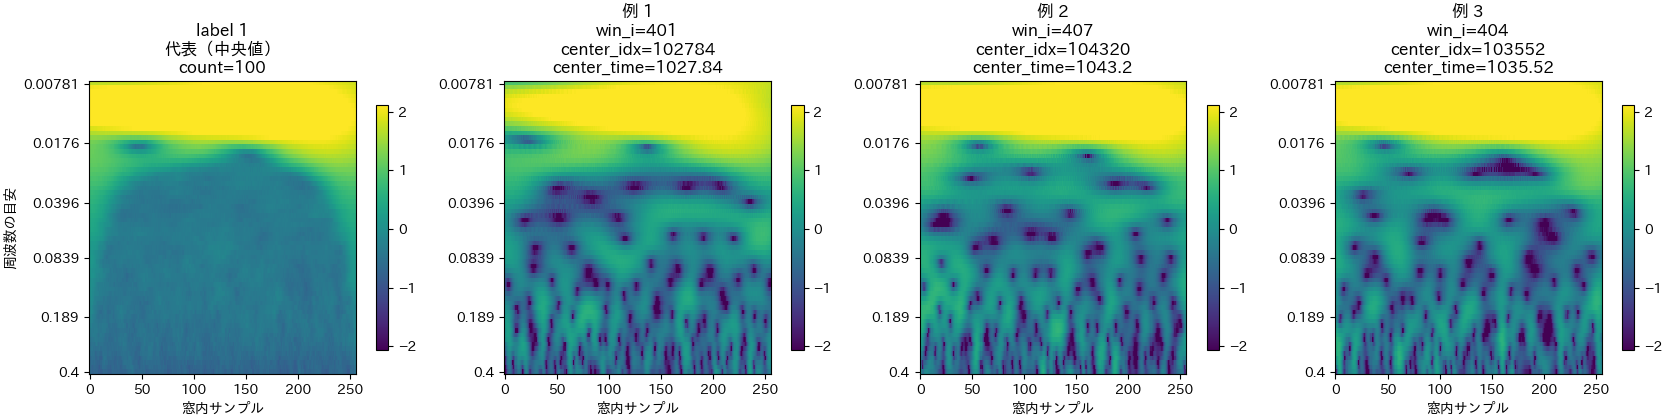

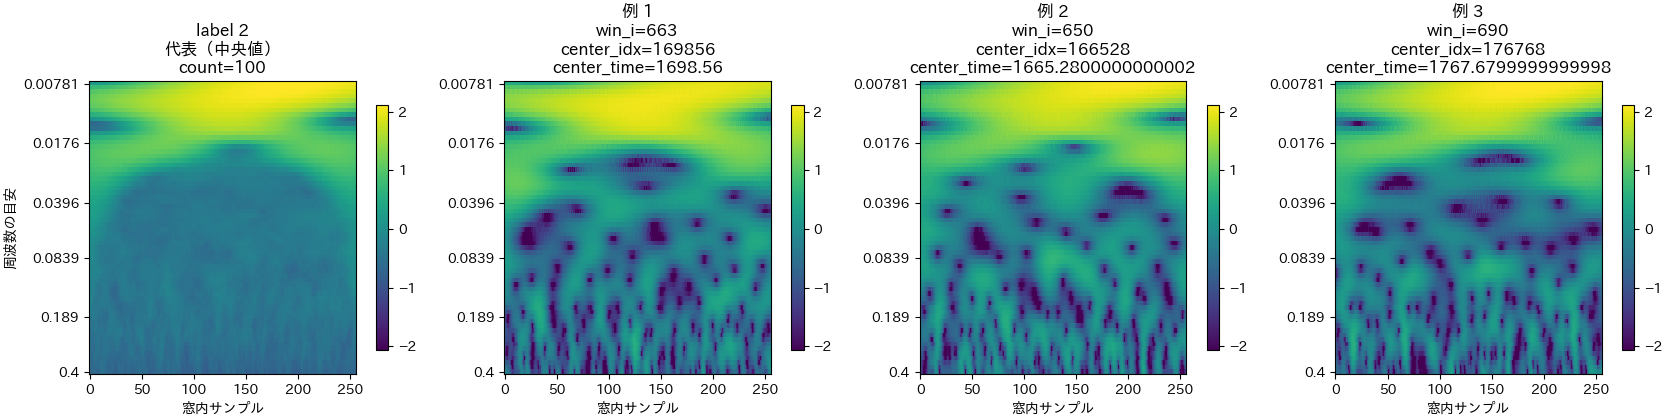

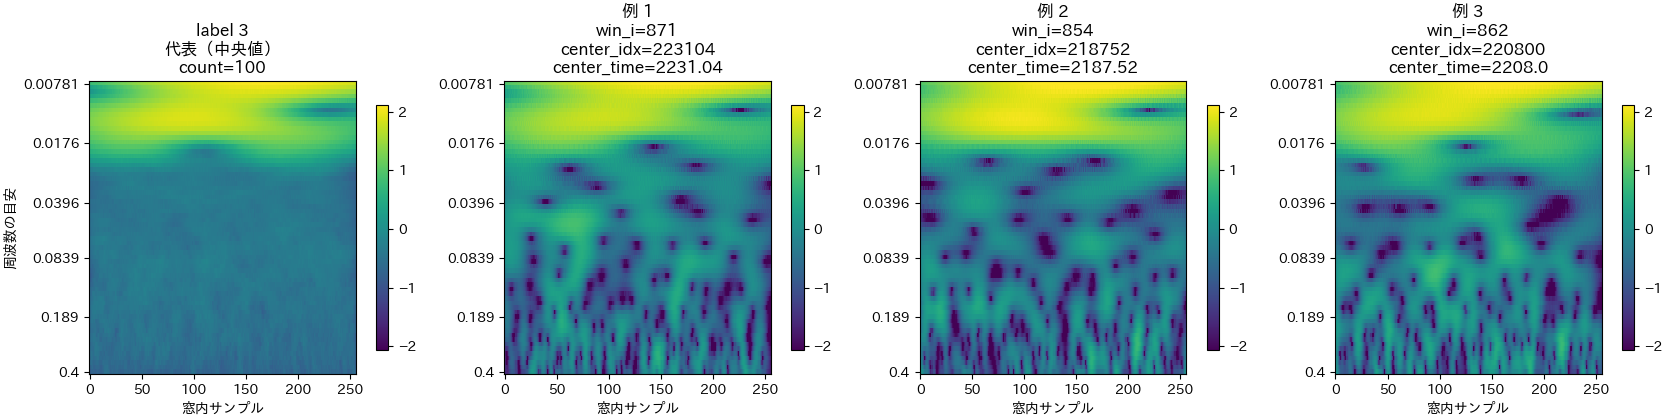

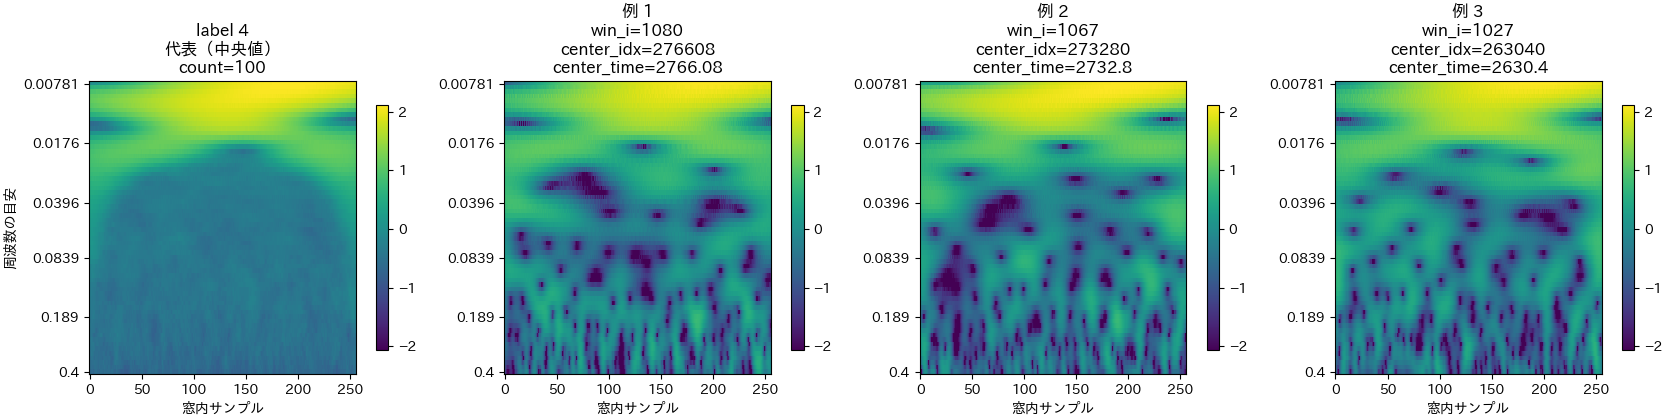

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# （任意）日本語表示したい場合
try:
    import japanize_matplotlib  # noqa
except Exception:
    pass

# ----------------------------
# 入力（あなたの変数名に合わせる）
# ----------------------------
X_SRC = Xcwt_te_n if "Xcwt_te_n" in globals() else Xcwt_te   # (N,S,T,C) or (N,S,T)
META  = meta_te                                             # DataFrame
FREQS = freqs_te if "freqs_te" in globals() else (freqs if "freqs" in globals() else None)

LABEL_COL = "win_label"   # meta_te 内のラベル列
SENSOR_IDX = 1            # 複数センサなら 0,1,2... を選ぶ
N_EXAMPLES = 3            # 各ラベルで見せる例の枚数
USE_MEDIAN = True         # 代表を中央値で作る（外れに強い）。Falseなら平均。
SEED = 0                  # 例の選び方の乱数

# ラベル表示名（任意）
label_name = None  # 例: {0:"正常", 1:"周波数変化", 2:"シフト"} など


# ----------------------------
# 取り出し関数（(S,T) を返す）
# ----------------------------
def get_frame(X, k, sensor_idx=0):
    if X.ndim == 4:
        return X[k, :, :, sensor_idx]
    if X.ndim == 3:
        return X[k, :, :]
    raise ValueError(f"X の shape が想定外です: {X.shape}")

def get_stack(X, idxs, sensor_idx=0):
    if X.ndim == 4:
        return X[idxs, :, :, sensor_idx]  # (n,S,T)
    if X.ndim == 3:
        return X[idxs, :, :]              # (n,S,T)
    raise ValueError(f"X の shape が想定外です: {X.shape}")


# ----------------------------
# 前提チェック
# ----------------------------
if META is None or LABEL_COL not in META.columns:
    raise ValueError(f"meta_te に '{LABEL_COL}' 列がありません（ラベルが必要です）")

N = X_SRC.shape[0]
if len(META) != N:
    raise ValueError(f"X と meta の窓数が一致しません: X={N}, meta={len(META)}")

# NaNを除いたラベル一覧
labs = META[LABEL_COL].to_numpy()
valid = ~np.isnan(pd.to_numeric(labs, errors="coerce")) if "pd" in globals() else np.isfinite(labs.astype(float, copy=False))
# ↑ pandas が無い場合にも動かしたいので一応。普段は pandas ある前提でOK。
try:
    valid = ~np.isnan(pd.to_numeric(labs, errors="coerce").to_numpy(dtype=float))
    lab_vals = labs[valid]
except Exception:
    lab_vals = labs

uniq_labels = np.unique(lab_vals)
print("labels:", uniq_labels)
print("counts:", {l: int(np.sum(labs == l)) for l in uniq_labels})

# 色スケールを固定（全テストから分位点）
A = (X_SRC[:, :, :, SENSOR_IDX].reshape(-1) if X_SRC.ndim == 4 else X_SRC.reshape(-1))
A = A[np.isfinite(A)]
vmin = float(np.quantile(A, 0.02)) if A.size else -1.0
vmax = float(np.quantile(A, 0.98)) if A.size else  1.0

rng = np.random.default_rng(SEED)

# ----------------------------
# ラベルごとに代表＋例を表示
# ----------------------------
for lab in uniq_labels:
    idxs = np.where(labs == lab)[0]
    if idxs.size == 0:
        continue

    # 代表（中央値 or 平均）: (S,T)
    Xstk = get_stack(X_SRC, idxs, SENSOR_IDX)  # (n,S,T)
    rep = np.median(Xstk, axis=0) if USE_MEDIAN else np.mean(Xstk, axis=0)

    # 例: ラベル内から最大 N_EXAMPLES 枚をランダム抽出（固定SEED）
    n_show = min(N_EXAMPLES, idxs.size)
    ex_idxs = rng.choice(idxs, size=n_show, replace=False)

    # タイトル用ラベル文字列
    if label_name is not None and lab in label_name:
        lab_str = f"{lab} ({label_name[lab]})"
    else:
        lab_str = str(lab)

    # 図：左が代表、右に例を並べる
    ncols = 1 + n_show
    fig, axes = plt.subplots(1, ncols, figsize=(4.2*ncols, 4.2), constrained_layout=True)

    if ncols == 1:
        axes = [axes]

    # 代表
    ax0 = axes[0]
    im0 = ax0.imshow(rep, origin="lower", aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax)
    ax0.set_title(f"label {lab_str}\n代表（{'中央値' if USE_MEDIAN else '平均'}）\ncount={idxs.size}")
    ax0.set_xlabel("窓内サンプル")
    ax0.set_ylabel("scale" if FREQS is None else "周波数の目安")
    fig.colorbar(im0, ax=ax0, fraction=0.046)

    # y軸を周波数表示（freqsがある場合）
    if FREQS is not None and len(FREQS) == rep.shape[0]:
        yt = np.linspace(0, rep.shape[0]-1, 6).astype(int)
        ax0.set_yticks(yt)
        ax0.set_yticklabels([f"{float(FREQS[i]):.3g}" for i in yt])

    # 例
    for j, k in enumerate(ex_idxs, start=1):
        ax = axes[j]
        fr = get_frame(X_SRC, int(k), SENSOR_IDX)
        im = ax.imshow(fr, origin="lower", aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax)

        # meta情報をタイトルに入れる（あれば）
        title = f"例 {j}\nwin_i={int(META.loc[k,'win_i']) if 'win_i' in META.columns else int(k)}"
        if "center_idx" in META.columns:
            title += f"\ncenter_idx={int(META.loc[k,'center_idx'])}"
        if "center_time" in META.columns:
            title += f"\ncenter_time={META.loc[k,'center_time']}"
        ax.set_title(title)
        ax.set_xlabel("窓内サンプル")
        ax.set_ylabel("")
        fig.colorbar(im, ax=ax, fraction=0.046)

        if FREQS is not None and len(FREQS) == fr.shape[0]:
            yt = np.linspace(0, fr.shape[0]-1, 6).astype(int)
            ax.set_yticks(yt)
            ax.set_yticklabels([f"{float(FREQS[i]):.3g}" for i in yt])

    plt.show()


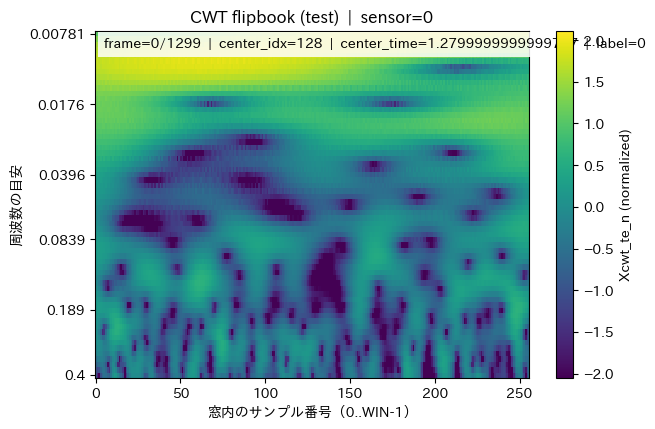

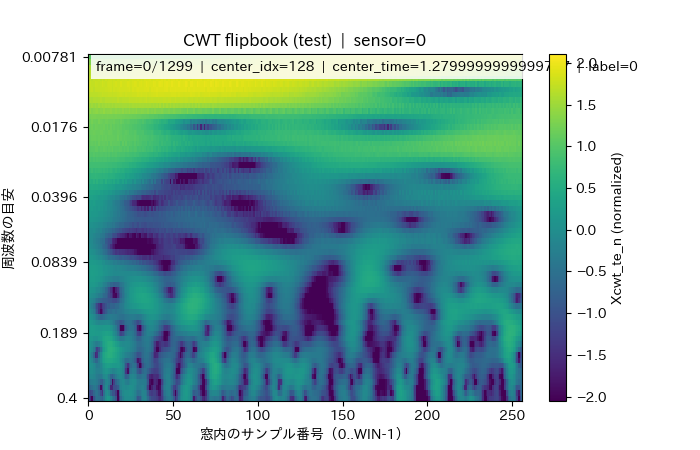

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import ipywidgets as widgets
from IPython.display import display

# ----------------------------
# 0) 表示に使うデータを選ぶ
# ----------------------------
if "Xcwt_te_n" in globals():
    X_SRC = Xcwt_te_n
    _src_name = "Xcwt_te_n (normalized)"
else:
    X_SRC = Xcwt_te
    _src_name = "Xcwt_te (raw log-power)"

# freqs（無ければ None でOK）
FREQS = None
if "freqs_te" in globals():
    FREQS = freqs_te
elif "freqs" in globals():
    FREQS = freqs

# meta（無ければ None でOK）
META = meta_te if "meta_te" in globals() else None

label_name = None
label_color = None

# ----------------------------
# 1) frame取得
# ----------------------------
def _get_frame(X, k: int, sensor_idx: int = 0) -> np.ndarray:
    if X.ndim == 4:
        return X[k, :, :, sensor_idx]
    if X.ndim == 3:
        return X[k, :, :]
    raise ValueError(f"X の shape が想定外です: {X.shape}")

def _robust_vmin_vmax(X, q_low=0.02, q_high=0.98, max_frames=200, seed=0, sensor_idx=0):
    N = X.shape[0]
    m = min(N, max_frames)
    rng = np.random.default_rng(seed)
    idx = np.arange(N) if m == N else rng.choice(N, size=m, replace=False)

    A = X[idx, :, :, sensor_idx].reshape(-1) if X.ndim == 4 else X[idx, :, :].reshape(-1)
    A = A[np.isfinite(A)]
    if A.size == 0:
        return -1.0, 1.0
    vmin = float(np.quantile(A, q_low))
    vmax = float(np.quantile(A, q_high))
    if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
        vmin, vmax = float(np.min(A)), float(np.max(A))
        if vmin == vmax:
            vmin, vmax = vmin - 1.0, vmax + 1.0
    return vmin, vmax

# ----------------------------
# 2) センサ選択
# ----------------------------
if X_SRC.ndim == 4:
    N, S, T, C = X_SRC.shape
else:
    N, S, T = X_SRC.shape
    C = 1

sensor_dropdown = None
if C > 1:
    if "SENSOR_COLS" in globals() and isinstance(SENSOR_COLS, (list, tuple)) and len(SENSOR_COLS) == C:
        sensor_names = list(SENSOR_COLS)
    else:
        sensor_names = [f"ch{j}" for j in range(C)]
    sensor_dropdown = widgets.Dropdown(
        options=[(sensor_names[j], j) for j in range(C)],
        value=0,
        description="sensor",
        layout=widgets.Layout(width="240px")
    )
    sensor_idx0 = int(sensor_dropdown.value)
else:
    sensor_idx0 = 0

vmin0, vmax0 = _robust_vmin_vmax(X_SRC, sensor_idx=sensor_idx0)

# ----------------------------
# 3) Figure（これを1回だけ表示する）
# ----------------------------
fig, ax = plt.subplots(figsize=(7.0, 4.5))
frame0 = _get_frame(X_SRC, 0, sensor_idx0)

im = ax.imshow(frame0, origin="lower", aspect="auto", interpolation="nearest", vmin=vmin0, vmax=vmax0)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(_src_name)

ax.set_xlabel("窓内のサンプル番号（0..WIN-1）")
if FREQS is not None and len(FREQS) == S:
    yt = np.linspace(0, S - 1, 6).astype(int)
    ax.set_yticks(yt)
    ax.set_yticklabels([f"{float(FREQS[i]):.3g}" for i in yt])
    ax.set_ylabel("周波数の目安")
else:
    ax.set_ylabel("scale index (0..S-1)")

txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    va="top", ha="left",
    bbox=dict(facecolor="white", alpha=0.85, edgecolor="none")
)

# ----------------------------
# 4) widgets（図はOutputに入れない＝2重表示防止）
# ----------------------------
play = widgets.Play(min=0, max=N - 1, step=1, interval=120, description="Play")
slider = widgets.IntSlider(
    min=0, max=N - 1, step=1, value=0,
    description="frame",
    continuous_update=True,
    readout=True,
    layout=widgets.Layout(width="520px")
)
widgets.jslink((play, "value"), (slider, "value"))

def _label_to_text_and_color(k: int):
    lab = None
    if META is not None and isinstance(META, pd.DataFrame) and "win_label" in META.columns and k < len(META):
        lab = META.loc[k, "win_label"]
    if label_name is not None and lab in label_name:
        lab_str = label_name[lab]
    else:
        lab_str = str(lab) if lab is not None else "N/A"
    col = None
    if label_color is not None and lab in label_color:
        col = label_color[lab]
    return lab_str, col

def _make_status_line(k: int) -> str:
    parts = [f"frame={k}/{N-1}"]
    if META is not None and isinstance(META, pd.DataFrame) and k < len(META):
        if "center_idx" in META.columns:
            parts.append(f"center_idx={META.loc[k,'center_idx']}")
        if "center_time" in META.columns:
            parts.append(f"center_time={META.loc[k,'center_time']}")
    lab_str, _ = _label_to_text_and_color(k)
    parts.append(f"label={lab_str}")
    return "  |  ".join(parts)

def _update(k: int, sensor_idx: int = 0):
    im.set_data(_get_frame(X_SRC, k, sensor_idx))
    lab_str, col = _label_to_text_and_color(k)
    txt.set_text(_make_status_line(k))
    txt.set_color(col if col is not None else "black")
    ax.set_title(f"CWT flipbook (test)  |  sensor={sensor_idx}")
    fig.canvas.draw_idle()

_update(0, sensor_idx0)

def _on_slider(change):
    k = int(change["new"])
    sensor_idx = int(sensor_dropdown.value) if sensor_dropdown is not None else 0
    _update(k, sensor_idx)

slider.observe(_on_slider, names="value")

def _on_sensor(change):
    sensor_idx = int(change["new"])
    vmin, vmax = _robust_vmin_vmax(X_SRC, sensor_idx=sensor_idx)
    im.set_clim(vmin, vmax)
    _update(int(slider.value), sensor_idx)

if sensor_dropdown is not None:
    sensor_dropdown.observe(_on_sensor, names="value")

# controls 表示
if sensor_dropdown is not None:
    display(widgets.HBox([sensor_dropdown, play, slider]))
else:
    display(widgets.HBox([play, slider]))

# 図は最後に1回だけ
display(fig)

